In [ ]:
import os
import ast
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm

from IPython.display import display

from PIL import Image
from pathlib import Path
from os import PathLike
from typing import Dict, Any

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

from ba_dev.eval_helpers import *

set_custom_plot_style()

In [3]:
run = LoadRun(
        log_path='/cfs/earth/scratch/kraftjul/BA/output/runs/efficient_v1'
        )

# dataset = run.get_dataset()

## Checking List of worst Predictions

In [8]:
predictions = run.get_predictions(filter_by='incorrect', sort='probs_max')
idx_to_check = predictions['idx'].tolist()
current_sample = 0

idx: 369261
true_class: 0 - apodemus_sp
pred_class: 2 - cricetidae
classification confidence: 1.0


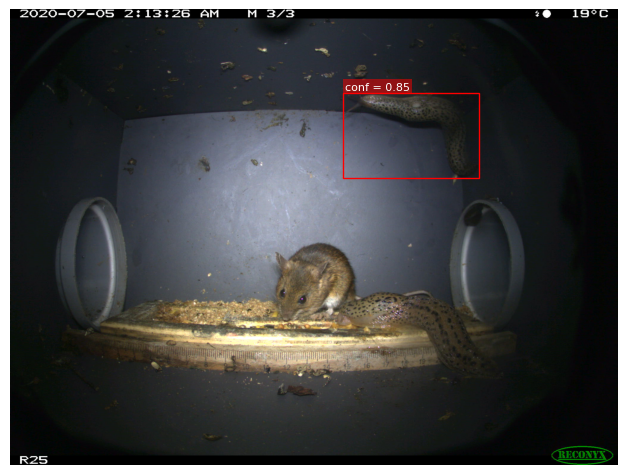

In [10]:
idx = idx_to_check[current_sample]
prediction = predictions.loc[predictions['idx'] == idx].squeeze().to_dict()

true_class = prediction["class_id"]
pred_class = prediction["pred_id"]

print(f'idx: {idx}')
print(f'true_class: {true_class} - {run.decoder[true_class]}')
print(f'pred_class: {pred_class} - {run.decoder[pred_class]}')
print(f'classification confidence: {prediction["probs_max"]}')
figure = run.show_sample(idx)

current_sample += 1


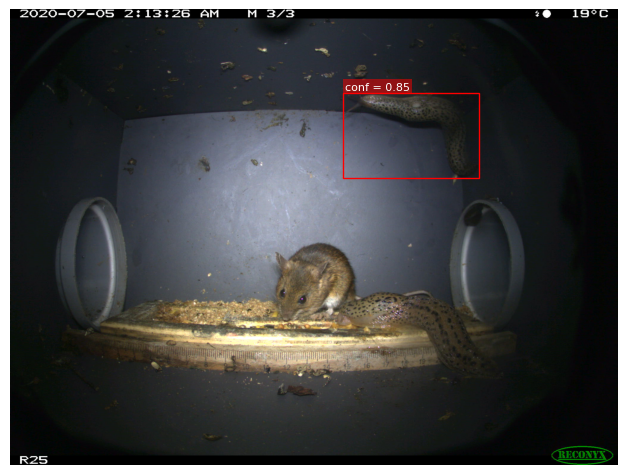

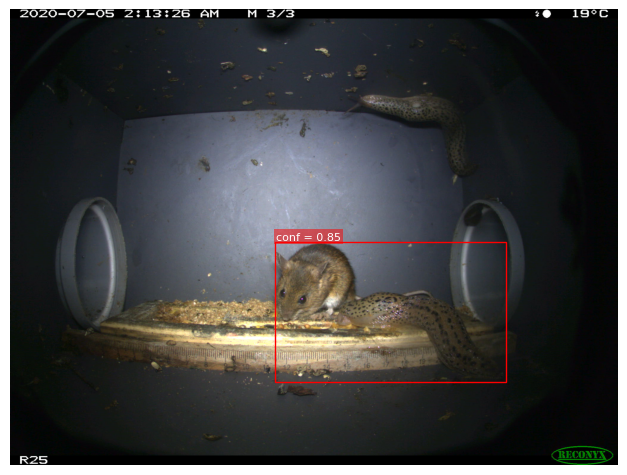

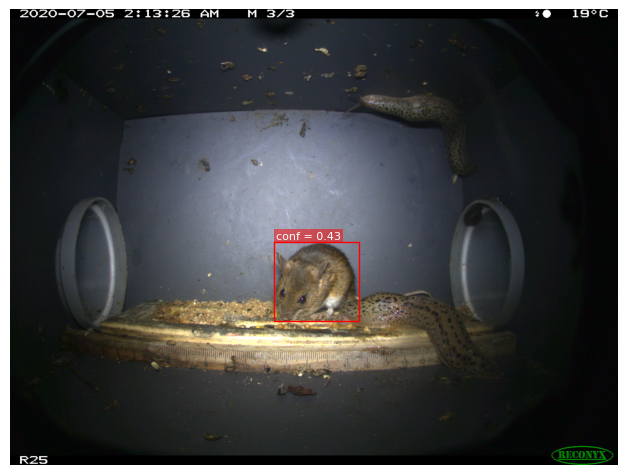

In [13]:
figures = run.show_all_bboxes_for_image(
    idx=idx
    )

## Plot Confusion Matrix

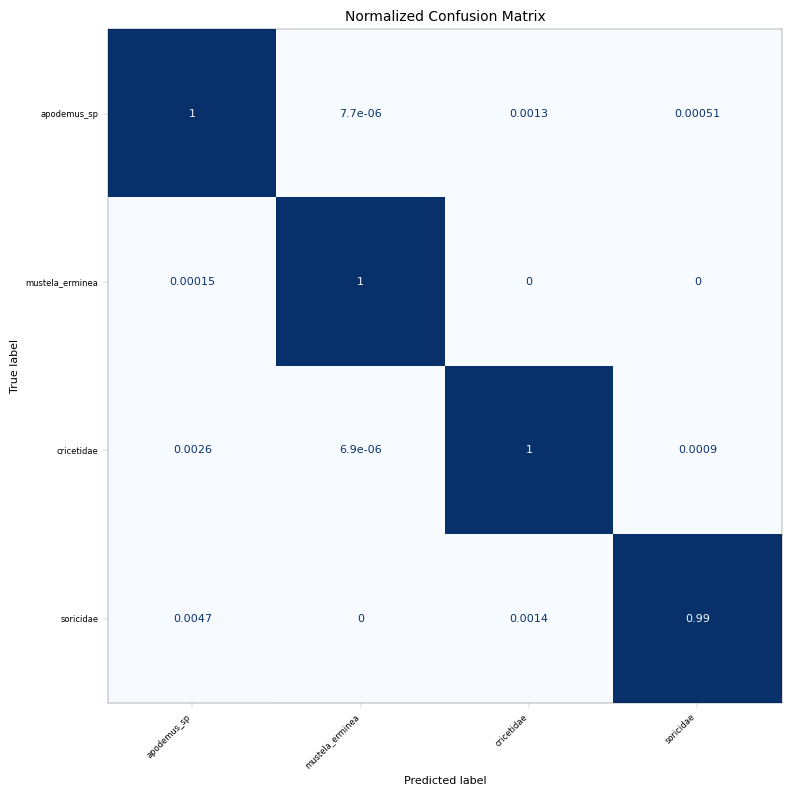

In [6]:
labels = list(run.info['output']['label_decoder'].values())

cm = run.calculate_metrics(
    'confusion_matrix',
    labels=[0, 1, 2, 3],
    normalize='true'
)

# 3) Create and plot the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Normalized Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Plot Metrics for Run

In [2]:
run_from_scratch = LoadRun(
        log_path='/cfs/earth/scratch/kraftjul/BA/output/runs/efficientnet_b0_v3_from_scratch'
        )

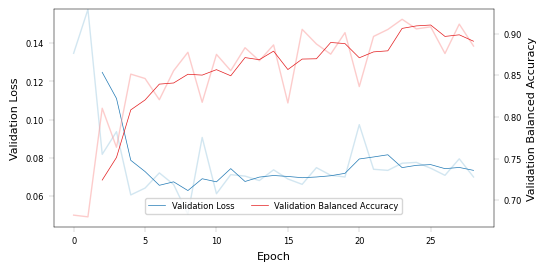

In [3]:
metrics = run_from_scratch.get_metrics()
best_model_loss = plot_model_metrics(
                        metrics=metrics,
                        title=None,
                        type='valid', 
                        step=False, 
                        image_size_cm=[14,7], 
                        window_size=3
                        )